# Proyecto Final

Iniciaremos nuestra exploración de los sistemas de recomendación con los ejemplos más básicos. Estos primeros ejemplos nos permitirán explorar nuestro conjunto de datos en primera instancia y, en casos concretos donde no dispongamos de datos pueden servir como una base o primera aproximación muy socorrida.

## Descarga de datos: MovieLens

Procederemos a descargar la información del conjunto de datos recopilado por el equipo de investigación [grouplens](https://grouplens.org/datasets/movielens/) de la Universidad de Minesota bajo su trabajo previo hecho público:

F. Maxwell Harper and Joseph A. Konstan. 2015. **The MovieLens Datasets: History and Context**. *ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872

Es un conjunto de datos muy utilizado en el ámbito de los sistemas de recomendación y por ello encontraremos multitud de ejemplos donde podremos ver representados los mismos datos y evaluar vuestras soluciones frente a las publicadas.

In [1]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlretrieve

In [2]:
# Descarga del conjunto de datos
print("Descargando el conjunto de datos...")

urlretrieve("https://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
info = zip_ref.read('ml-100k/u.info')

print(f"Descargado! Numero de elementos descargados {info}")

Descargando el conjunto de datos...
Descargado! Numero de elementos descargados b'943 users\n1682 items\n100000 ratings\n'


## Usuarios (Users)

Como toda plataforma los usuarios son la pieza clave que motiva las necesidades de recomendación. Por ello deberemos conocer bien a nuestro público.

In [3]:
# Cargamos los datos de los usuarios
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Podemos ver cómo es la estructura base de nuestro conjunto de usuarios donde disponemos de rangos de edad, sexo, ocupación y código postal informado.

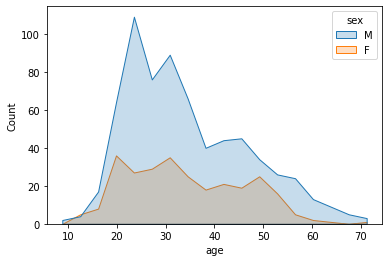

In [4]:
# Muestra ejemplo de la distribución de edad por sexo
sns.histplot(users, x="age", hue="sex", element="poly")

También podemos entender como es la distribución de edad por ocupación. Este tipo de conocimiento es lo que en muchos casos permite hacer asunciones de los gustos base que esperamos en poblaciones concretas por ocupación, rango de edad, país de residencia,...

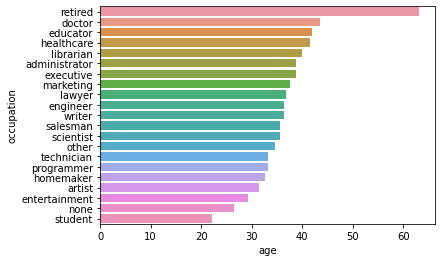

In [5]:
data = users.groupby("occupation")["age"].mean()
data = data.reset_index().sort_values("age", ascending=False)
sns.barplot(y="occupation",x="age", data=data)


También podemos obtener los datos relativos a las ocupaciones con mayor actividad en la plataforma.

In [6]:
users.groupby("occupation")["age"].count().sort_values(ascending=False)

occupation
student          196
other            105
educator          95
administrator     79
engineer          67
programmer        66
librarian         51
writer            45
executive         32
scientist         31
artist            28
technician        27
marketing         26
entertainment     18
healthcare        16
retired           14
lawyer            12
salesman          12
none               9
homemaker          7
doctor             7
Name: age, dtype: int64

In [7]:
common_users = users[users["occupation"].isin(["student", "other","educator"])]

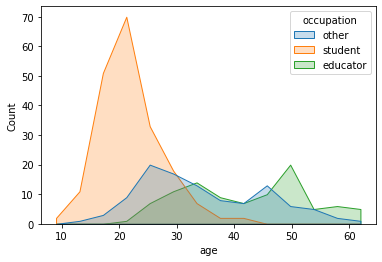

In [8]:
sns.histplot(common_users, x="age", hue="occupation", element="poly")

## Ítems (Movies)

Las películas serán para nosotros los items a recomendar a nuestros usuarios. Obtendremos los datos del conjunto base y además complementaremos aquella información que enriquezca nuestro conocimiento sobre estas pelíoculas de cara a recomendar aquellas que sean del agrado de nuestros usuarios.

In [9]:
# Cargamos las películas
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Obtenemos el año de la fecha de publicación
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
movies.head(10)

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1995
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1996


Podemos ver que el conjunto de base ya contiene el etiquetado de los generos de cada película en formato [OneHotEncoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). Es una forma sencilla de codificar variables categoricas de forma que podamos utilizarlas de forma numérica. 

Veamos ahora cual es la distribución de nuestros ítems por genero.

In [10]:
#Distribución de ítems por género 

df = movies[genre_cols].sum().sort_values(ascending=False)
df

Drama            725
Comedy           505
Action           251
Thriller         251
Romance          247
Adventure        135
Children         122
Crime            109
Sci-Fi           101
Horror            92
War               71
Mystery           61
Musical           56
Documentary       50
Animation         42
Western           27
Film-Noir         24
Fantasy           22
genre_unknown      2
dtype: int64

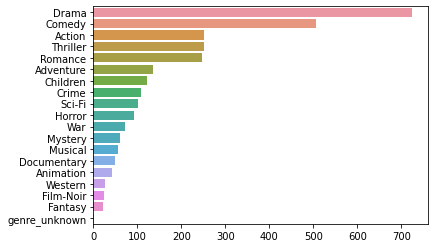

In [11]:
x = df.tolist()
y = df.index.tolist()
sns.barplot(x=x,y=y)

Disponemos de información relativa al contenido, pero es importante poder valorar qué películas son las mejor valoradas entre el público o cuales son las más populares (más vistas). Para ello deberemos cargar el tercer conjunto relevante para nuestro sistema de recomendación.

## Ratings

Finalmente, los ratings son los que recogen las impresiones de los usuarios con respecto a los ítems, dandonos la posibilidad de adecuar en base a dichos gustos la oferta a cada usuario.

In [12]:
# Cargamos las puntuaciones otorgadas por usuarios a películas vistas en un rango entre 1 a 5
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


Gracias a estos rating podremos, por ejemplo, buscar aquellas películas más populares.

In [13]:
# Películas mas valorados más veces

titles = movies[['title', 'movie_id']]
df = pd.merge(ratings, titles, on='movie_id')

df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [14]:
df

,user_id,movie_id,rating,unix_timestamp,title
0,196,242,3.0,881250949,Kolya (1996)
1,63,242,3.0,875747190,Kolya (1996)
2,226,242,5.0,883888671,Kolya (1996)
3,154,242,3.0,879138235,Kolya (1996)
4,306,242,5.0,876503793,Kolya (1996)
...,...,...,...,...,...
99995,840,1674,4.0,891211682,Mamma Roma (1962)
99996,655,1640,3.0,888474646,"Eighth Day, The (1996)"
99997,655,1637,3.0,888984255,Girls Town (1996)
99998,655,1630,3.0,887428735,"Silence of the Palace, The (Saimt el Qusur) (1..."


Veremos que las películas más populares pueden no ser las mejor valoradas.

In [15]:
# Películas mejor valoradas

df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
They Made Me a Criminal (1939)                5.0
Marlene Dietrich: Shadow and Light (1996)     5.0
Saint of Fort Washington, The (1993)          5.0
Someone Else's America (1995)                 5.0
Star Kid (1997)                               5.0
Name: rating, dtype: float64

Una vez conocemos nuestro conjunto de datos podemos plantearnos cómo deberían ser esas primeras recomendaciones a realizar.

# Recomendadores por popularidad

Es uno de los ejemplos más sencillos donde no se requiere información alguna de los usuarios. Los ítems más populares pueden ser un buen reclamo ante la presencia de un usuario del que nos dispongamos de información. En el ámbito de los recomendadores esta carencia de información se conoce como *cold start*.

Permite presentar a un nuevo usuario de una plataforma con información posiblemente de su interés dada la popularidad de esta para otros usuarios.

Podemos buscar la relación entre las métricas anteriormente vistas (número de puntuaciones y promedio de las mismas) de cara a entender mejor la relación existente entre estas. Nuestro primer recomendador podría simplemente ofrecernos la películas más populares o las mejor valoradas (o una combinación de ambas). Crearemos un conjunto de datos base que deberemos actualizar cada vez que se disponga de nueva información sobre nuestra colección de ítems (películas).

In [16]:
ratings_df = pd.DataFrame(df.groupby('movie_id')['rating'].count())
ratings_df

,rating
movie_id,
1,452
2,131
3,90
4,209
5,86
...,...
1678,1
1679,1
1680,1


### Construcción de DataFrame que combina los índices de popularidad y mejor valorados para los películas

In [17]:
# Renombramos el campo
ratings_df.rename(columns={'rating': 'num_rating'}, inplace=True)
# Calculamos el promedio de las puntuaciones
ratings_df['mean_ratings'] = pd.DataFrame(df.groupby('movie_id')['rating'].mean())
# Y la puntuación final como el producto entre ambas
ratings_df['score'] = ratings_df['mean_ratings'] * ratings_df['num_rating']
ratings_df.sort_values(by='score', ascending=False).head()

,num_rating,mean_ratings,score
movie_id,,,
50,583,4.358491,2541.0
100,508,4.155512,2111.0
181,507,4.007890,2032.0
258,509,3.803536,1936.0
174,420,4.252381,1786.0


Con esta información podremos en base a la popularidad de las películas no vistas por el usuario, realizar una primera recomendación.

### Cuáles son las diez películas más vistas y mejor valoradas que no haya visto el usuario indicado por user_id

In [18]:
def popularity_based_recommender(user_id:int):
 
  # Obtenemos 100 candidatos a ser recomendados (por disponer de una muestra de generación)
  top_rated = ratings_df.sort_values(by='score', ascending=False).head(100)

  # Obtenemos las películas ya vistas por el usuario
  already_seen = ratings[ratings["user_id"] == user_id]["movie_id"]

  # Nos quedamos con aquellas no vistas del conjunto inicial
  not_seen = top_rated.merge(already_seen.drop_duplicates(), on=['movie_id','movie_id'], how='left', indicator=True)
  return_df = not_seen[not_seen['_merge'] == 'left_only']["movie_id"]

  # Añadimos el título y ofrecemos diez candidatas
  return pd.merge(return_df, titles, on='movie_id')["title"].head(10)


In [19]:
popularity_based_recommender(1)

0               English Patient, The (1996)
1                             Scream (1996)
2                      Air Force One (1997)
3                          Liar Liar (1997)
4                            Titanic (1997)
5                   Schindler's List (1993)
6                  L.A. Confidential (1997)
7         E.T. the Extra-Terrestrial (1982)
8                Mission: Impossible (1996)
9    One Flew Over the Cuckoo's Nest (1975)
Name: title, dtype: object

In [20]:
popularity_based_recommender(50)

0                    Star Wars (1977)
1           Return of the Jedi (1983)
2                      Contact (1997)
3      Raiders of the Lost Ark (1981)
4               Godfather, The (1972)
5                    Toy Story (1995)
6    Silence of the Lambs, The (1991)
7                 Pulp Fiction (1994)
8                Air Force One (1997)
9     Empire Strikes Back, The (1980)
Name: title, dtype: object

In [21]:
popularity_based_recommender(100)

0                    Star Wars (1977)
1                        Fargo (1996)
2           Return of the Jedi (1983)
3      Raiders of the Lost Ark (1981)
4               Godfather, The (1972)
5                    Toy Story (1995)
6    Silence of the Lambs, The (1991)
7                 Pulp Fiction (1994)
8     Empire Strikes Back, The (1980)
9               Twelve Monkeys (1995)
Name: title, dtype: object

Esta modalidad de recomendación es quizás de las más sencillas y en cualquier caso, únicamente disponiendo de la información asociada a los ítems vistos por los usuarios puede contarse con una recomendación sobre los títulos más populares. Dentro del caracter general de estos modos de recomendación estas recomendaciones pueden ser segregadas por popularidad entre adolescentes o algún perfil laboral en concreto para lo cual necesitaremos algo más de información asociada al usuario en cuestión que valoramos.

# La importancia de la similitud

Un factor interesante a la hora de recomendar contenido es la similitud que este pueda presentar con contenido ya visto por el usuario en cuestión y del que haya mostrado buen feedback (ratings altos en nuestro caso).

Veremos que este mismo concepto es extensible a los usuarios (contenido visto por usuarios similares a mi) pero por el momento nos limitaremos a conocer los gustos de nuestro usuario candidato. Para ello deberemos obtener sus películas favoritas.

###  Los 10 títulos mejor valorados por un usuario

In [22]:
def favorite_movies(user_id:int, num=10):
 
  # Obtenemos las películas ya vistas por el usuario
  rated = ratings[ratings["user_id"] == user_id]
  
  # Las películas valoradas por este
  rated_info = pd.merge(rated, titles, on='movie_id')[["movie_id","title","rating"]]
  return rated_info.sort_values(by='rating', ascending=False).head(num)

In [23]:
favorite_movies(150)

,movie_id,title,rating
1,181,Return of the Jedi (1983),5.0
10,127,"Godfather, The (1972)",5.0
26,276,Leaving Las Vegas (1995),5.0
13,50,Star Wars (1977),5.0
6,246,Chasing Amy (1997),5.0
12,268,Chasing Amy (1997),5.0
11,475,Trainspotting (1996),5.0
19,410,Kingpin (1996),4.0
21,458,Nixon (1995),4.0
0,293,Donnie Brasco (1997),4.0


In [24]:
favorite_movies(1)

,movie_id,title,rating
136,170,Cinema Paradiso (1988),5.0
67,175,Brazil (1985),5.0
182,119,Maya Lin: A Strong Clear Vision (1994),5.0
186,181,Return of the Jedi (1983),5.0
191,109,Mystery Science Theater 3000: The Movie (1996),5.0
77,44,Dolores Claiborne (1994),5.0
75,14,"Postino, Il (1994)",5.0
74,12,"Usual Suspects, The (1995)",5.0
194,223,Sling Blade (1996),5.0
72,108,Kids in the Hall: Brain Candy (1996),5.0


Conociendo los gustos de los usuarios sería interesante poder recomendar películas _similares_ de forma que maximicemos la experiencia de nuestro usuario. Podemos así ofrecerle contenido afin a sus gustos registrados. Y aquí es donde entran en juego las méticas de similitud.

Las métricas de similitud pretenden establecer un valor numérico de cómo de similares son dos elementos. El rango variará en base a la métrica en cuestión de modo que os presentamos algunas de las más comunes.

## Similitud coseno

Es una métrica popular ya que nos permite disponer de una métrica indicando 0 como dos elementos nada similares y 1 cuendo los elementos comparados son idénticos. Su formulación se expresa:

$S_c(A,B) = cos(\theta) = \frac{A · B}{\|A\|\|B\|} = \frac{\sum_{i=1}^n A_iB_i}{\sqrt{\sum_{i=1}^n A_i^2 \sum_{i=1}^n B_i^2}} $

donde $A_i$ y $B_i$ son los componentes de los vectores formados por las características de nuestros items. En el próximo ejemplo veremos cómo podemos comparar muestras basadas en los generos informados.


## Distancia de Jaccard

Formulada como se muestra a continuación:

$ J(A, B) = \frac{|A \cap B|}{|A \cup B|}$

Establece el número de elementos que se encuentran en la conjunción de ambos conjuntos (en nuestro caso podrían ser los generos asociados a una película) y en base a esto establece un índice donde la total coincidencia dará como resultado 1.0. 

En muchos casos no hará falta que codifiquemos nosotros mismos estas métricas ya que existen muchas de ellas ya codificadas bajo la librería *sklearn* en su sección de [métricas](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise).

### Calculamos la matriz de similitud de los ítems seleccionando unicamente el comapo "movie_id" y las columnas de generos

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

data = movies[['title']+genre_cols].set_index('title')
cosine_sim = cosine_similarity(data)

Con esto hemos construido un comparador basado en los géneros de las películas, de modo que si indicamos que nos gusta un Drama nos ofrecerá títulos simialres (Dramas). Evidentemente, cuanta más información dispongamos del contenido más precisas serán estas métricas.

In [26]:
# Convertimos nuestra matriz en un DataFrame con índices y columnas indicando la relación entre películas
sim_matrix = pd.DataFrame(cosine_sim)
sim_matrix.columns = movies['movie_id'].values
sim_matrix.index += 1
sim_matrix

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,1.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000
2,0.000000,1.000000,0.577350,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.816497,0.000000,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.00000,0.000000
3,0.000000,0.577350,1.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.00000,0.000000
4,0.333333,0.333333,0.000000,1.000000,0.333333,0.577350,0.408248,0.666667,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.000000,0.408248,0.57735,0.577350
5,0.000000,0.333333,0.577350,0.333333,1.000000,0.577350,0.408248,0.333333,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.408248,0.408248,0.00000,0.577350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.000000,0.000000,0.000000,0.577350,0.577350,1.000000,0.707107,0.577350,1.000000,0.707107,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.707107,0.00000,1.000000
1679,0.000000,0.408248,0.707107,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.00000,0.000000
1680,0.000000,0.000000,0.000000,0.408248,0.408248,0.707107,0.500000,0.408248,0.707107,0.500000,...,0.000000,0.707107,0.707107,0.707107,0.707107,0.707107,0.500000,1.000000,0.00000,0.707107
1681,0.577350,0.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.577350,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000


In [27]:
def find_similar(movie_id):
  # Obtenemos las métricas para las peliculas
  m_list = sim_matrix.loc[movie_id].tolist()
  # Filtramos por aquellas simialres
  similar_movies = [i+1 for i,x in enumerate(m_list) if x >= 0.99]
  # Devolvemos los titulos
  return movies[movies["movie_id"].isin(similar_movies)][["title"] + genre_cols]

In [28]:
find_similar(1)

,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Toy Story (1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
421,Aladdin and the King of Thieves (1996),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
find_similar(7)

,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
6,Twelve Monkeys (1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
257,Contact (1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
428,"Day the Earth Stood Still, The (1951)",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1005,Until the End of the World (Bis ans Ende der W...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [30]:
find_similar(1500)

,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
12,Mighty Aphrodite (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
24,"Birdcage, The (1996)",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
25,"Brothers McMullen, The (1995)",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
39,"To Wong Foo, Thanks for Everything! Julie Newm...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
40,Billy Madison (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,Chairman of the Board (1998),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1658,Getting Away With Murder (1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1663,8 Heads in a Duffel Bag (1997),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1667,Wedding Bell Blues (1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Al igual que la similitud de coseno, disponemos de otras métricas como la *distancia de Jaccard* o la *correlación de Pearson* que aportan esta misma visión sobre la proximidad entre distintos items en base a sus campos informados. Podemos completar los datos disponibles con información sobre los actores de las películas, lenguajes en las que se encuentran disponibles o directores de forma que cuanta más información contextual tengamos sobre los items, más precisas serán las métricas de similitud. Existen escenarios donde una métricas ofrecerán resultados más robustos que el resto, debido a la codificación de los campos, uso de valores discretos o conínuos, etc. Será nuestra labor entender cual es la mejor métrica en cada caso.

Estas métrica de similitud nos permiten realizar recomendaciones mucho más elavoradas que permitan adecuar las recomendaciones a los gustos del usuario basados en contenidos similares.

# Recomendadores basadas en contenido

El **filtrado basado en contenido** nos permite definir una vez conocemos los gustos y preferencias de un usuario (ítems visitados, visualizados o puntuados) ofrecerle ítems similares (basados en alguna distancia).

Una ves los usuarios empiezan a interactuar con la plataforma y a ofrecernos información sobre directores o actores favoritos podemos tener en cuenta estos gustos a la hora de recomendar la películas donde estos aparezcan.

En nuestro caso, podremos recurrir a los generos más consumidos o mejor valorados.

### Listado de películas indicadas a recomendar que el usuario no haya visto y sean similares a las películas vistas y puntuadas con un rating alto por el mismo usuario.

In [31]:
def content_based_recommender(user_id, num=10):
 
   # Películas mejor puntuadas por el usuario
   fav_movies = favorite_movies(user_id, 10)

   # Películas no vistas por el usuario (candidatas)
   already_seen = ratings[ratings["user_id"] == user_id]["movie_id"]
   not_seen = movies.merge(already_seen.drop_duplicates(), on=['movie_id','movie_id'], how='left', indicator=True)
   not_seen_id = not_seen[not_seen['_merge'] == 'left_only']["movie_id"]

   # Para cada película buscamos en su matriz de similitud lo títulos más similares, 
   # su máxima similitud con las películas valoradas y nos quedamos con las primeras
   value_matrix = sim_matrix[fav_movies["movie_id"].to_list()]
   movies_to_recommend = value_matrix.loc[not_seen_id.to_list()]
   movies_to_recommend['average'] = movies_to_recommend.mean(numeric_only=True, axis=1)
   chosen_movies = movies_to_recommend['average'].sort_values(ascending=False).head(num).reset_index()["index"].to_list()

   return titles[titles["movie_id"].isin(chosen_movies)]

In [32]:
favorite_movies(196)

,movie_id,title,rating
27,285,Secrets & Lies (1996),5.0
14,692,"American President, The (1995)",5.0
4,655,Stand by Me (1986),5.0
5,67,Ace Ventura: Pet Detective (1994),5.0
31,153,"Fish Called Wanda, A (1988)",5.0
8,663,Being There (1979),5.0
12,286,"English Patient, The (1996)",5.0
15,8,Babe (1995),5.0
29,1007,Waiting for Guffman (1996),4.0
30,411,"Nutty Professor, The (1996)",4.0


In [33]:
content_based_recommender(196)

,title,movie_id
344,Deconstructing Harry (1997),345
346,Wag the Dog (1997),347
736,Sirens (1994),737
903,Ma vie en rose (My Life in Pink) (1997),904
1102,Trust (1990),1103
1338,Stefano Quantestorie (1993),1339
1556,Yankee Zulu (1994),1557
1568,"Vie est belle, La (Life is Rosey) (1987)",1569
1587,Salut cousin! (1996),1588
1632,Á köldum klaka (Cold Fever) (1994),1633


In [34]:
favorite_movies(1)

,movie_id,title,rating
136,170,Cinema Paradiso (1988),5.0
67,175,Brazil (1985),5.0
182,119,Maya Lin: A Strong Clear Vision (1994),5.0
186,181,Return of the Jedi (1983),5.0
191,109,Mystery Science Theater 3000: The Movie (1996),5.0
77,44,Dolores Claiborne (1994),5.0
75,14,"Postino, Il (1994)",5.0
74,12,"Usual Suspects, The (1995)",5.0
194,223,Sling Blade (1996),5.0
72,108,Kids in the Hall: Brain Candy (1996),5.0


In [35]:
content_based_recommender(1)

,title,movie_id
336,"House of Yes, The (1997)",337
511,Wings of Desire (1987),512
516,Manhattan (1979),517
691,"American President, The (1995)",692
730,"Corrina, Corrina (1994)",731
774,Something to Talk About (1995),775
935,Brassed Off (1996),936
1099,What Happened Was... (1994),1100
1114,Twelfth Night (1996),1115
1423,I Like It Like That (1994),1424


# Filtrado colaborativo

El filtrado colaborativo es una familia de aproximaciones algorítmicas basadas en el comportamiento colaborativo y colectivo. Esto permite realizar una definición a futuro de posibles feedback esperado bajo la matríz de ratings. Podemos encontrar filtrados basados en la similitud entre usuarios (User Based Collaborative Filtering) o basado en ítems (Item Based Colaborative Filtering).

El filtrado colaborativo basado en usuarios es el predecesor de los basados en ítems. Este permite encontrar usuarios similares basado en la información disponible sobre estos recomendando artículos consumidos por usuarios similares y que no hayan sido consumidos por el sujeto inicial.

In [36]:
# Users
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

# Movies
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Obtenemos el año de la fecha de publicación
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

# Ratings
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

Aunque potente, existen ciertos problemas identificados en este tipo de sistemas.

*   Escalabilidad (scalability), debido al volumen del conjunto de datos y metodologías empleadas. Poder entrenar modelos o disponer de la memoria suficiente para gestionar el volumen de datos puede resultar un reto.

*   Escasez (sparsity) debido a que en la mayoría de sistemas son unos pocos usuarios los que generan el contenido haciendo dificil generalizar cuendo no se cuenta con suficiente información del grupo de usuarios.

Podemos analizar cómo se distribuyen los ratings por usuario y por ítem de cara a entender la distribución de los datos.

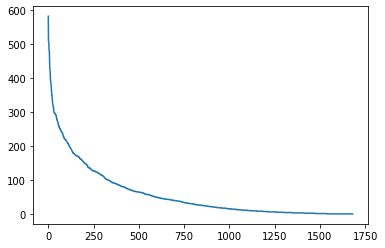

In [37]:
df = ratings.groupby('movie_id')["rating"].count().sort_values(ascending=False)
x = range(len(df))
y = df.tolist()
sns.lineplot(x=x, y=y)

Podemos ver que existen bloques de películas con muchas más puntuaciones que otras con lo que nuestras recomendaciones pueden verse afectadas por ese sesgo. Y sucede de identica manera si evaluamos cómo de activos son los usuarios aportando su feedback.

### Evaluación de usuarios de acuerdo a su feedback

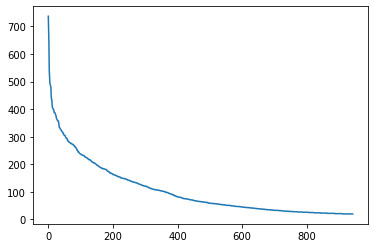

In [38]:
df = ratings.groupby('user_id')["rating"].count().sort_values(ascending=False)
x = range(len(df))
y = df.tolist()
sns.lineplot(x=x, y=y)

Si nuestro sistema sufre de una o ambas problemáticas, su efectividad puede verse impactada (Sarwar et al.,2001) generando desconfianza en las recomendaciones generadas y alterando la experiencia de los usuarios.

En los sistemas iniciales donde la disparidad de productos era menor y con mayor contexto se optó por utilizar sistemas de recomendación basado en la similitud de los items (inicialmente propuesto por Amazon y adoptado por otras plataformas (Netflix, Youtube, etc.). Estos recomendadores permiten comparar items y ofrecer aquellos similares a items previamente consumidos por el usuario (y sobre los que tengamos un feedback o rating positivo).

# Matriz de ratings

Es el corazón de los sistemas de recomendación basados en filtros colaborativos. Encapsula todo el conocimiento que disponemos en lo que respecta a la interacción y satisfacción entre usuarios e ítems. Podemos construir nuestra martriz pero deberemos tener en cuenta que muchos pares item-usuario seguramente no cuenten con la información necesaria (no lo han visto o puntuado, no disponemos de feedback en esa celda).

In [39]:
ratings.pivot('user_id','movie_id','rating')

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Deberemos tomar una decisión "ejecutiva" de cómo tratar estos campos. Podemos emplear distintas estrategias (imputación de medias, imputación de ceros,...) pero dada la escasez de información es dificil disponer de suficiente soporte estadístico como para que cualquiera de estas estrategias no introduzca un alto nivel de ruido en cada caso.

Probemos con una aproximación sencilla de inputación de ceros.

### Imputación de ceros a los valores faltantes

In [40]:
user_item_m = ratings.pivot('user_id','movie_id','rating').fillna(0)
user_item_m

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## User Based Collaborative Filtering 

Esta es la matríz que emplearemos para evaluar la similitud entre usuarios (usuarios que opinan parecido).

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

X_user = cosine_similarity(user_item_m)
X_user

array([[1.        , 0.16693098, 0.04745954, ..., 0.14861694, 0.17950788,
        0.39817474],
       [0.16693098, 1.        , 0.11059132, ..., 0.16148478, 0.17226781,
        0.10579788],
       [0.04745954, 0.11059132, 1.        , ..., 0.10124256, 0.13341615,
        0.02655587],
       ...,
       [0.14861694, 0.16148478, 0.10124256, ..., 1.        , 0.1016418 ,
        0.09511958],
       [0.17950788, 0.17226781, 0.13341615, ..., 0.1016418 , 1.        ,
        0.18246466],
       [0.39817474, 0.10579788, 0.02655587, ..., 0.09511958, 0.18246466,
        1.        ]])

# COMPLETAR

In [42]:
def find_similar_users(user_id, thresh=0.65):
  usr_rnk = np.where(X_user[user_id-1] >= thresh)[0].tolist()
  return users.loc[usr_rnk]["user_id"].to_list()

In [43]:
uid = find_similar_users(1)
users[users["user_id"].isin(uid)]

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711


Parece ser nadie opina como nuestro primer usuario. Tiene unos gustos muy particulares. Más adelante veremos como este efecto no es exclusivo de los usuariso.

In [44]:
uid = find_similar_users(196)
users[users["user_id"].isin(uid)]

,user_id,age,sex,occupation,zip_code
195,196,49,M,writer,55105


## Item Based Collaborative Filtering 

Podemos también basarnos en ítems que muestran una respuesta similar en los usuarios. Este caso suele dar mejores resultados dado que la similitud entre ítems es más confiable en contraposición a la de los usuarios. Por mucha información que dispongamos es más fácil establecer objetos similares de forma general.

In [45]:
X_item = cosine_similarity(user_item_m.T)
X_item

array([[1.        , 0.40238218, 0.33024479, ..., 0.        , 0.04718307,
        0.04718307],
       [0.40238218, 1.        , 0.27306918, ..., 0.        , 0.07829936,
        0.07829936],
       [0.33024479, 0.27306918, 1.        , ..., 0.        , 0.        ,
        0.09687505],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.04718307, 0.07829936, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.04718307, 0.07829936, 0.09687505, ..., 0.        , 0.        ,
        1.        ]])

# COMPLETAR

In [46]:
def find_similar_items(item_id, thresh=0.65):
  item_rnk = np.where(X_item[item_id-1] >= thresh)[0].tolist()
  return movies.loc[item_rnk]["movie_id"].to_list()

In [47]:
sim_item = find_similar_items(1)
movies[movies["movie_id"].isin(sim_item)]

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
49,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,...,0,0,0,0,1,1,0,1,0,1977
116,117,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1996
120,121,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1996
180,181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,...,0,0,0,0,1,1,0,1,0,1997


In [48]:
sim_item = find_similar_items(1500)
movies[movies["movie_id"].isin(sim_item)]

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
1320,1321,Open Season (1996),10-May-1996,NaN,http://us.imdb.com/Title?Open+Season+(1996),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1996
1485,1486,Girl in the Cadillac (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Girl%20in%20t...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1490,1491,Tough and Deadly (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Tough%20and%2...,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
1491,1492,Window to Paris (1994),01-Jan-1994,NaN,http://us.imdb.com/Title?Okno+v+Parizh+(1994),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1994
1492,1493,"Modern Affair, A (1995)",06-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Modern%20Affa...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1996
1493,1494,"Mostro, Il (1994)",19-Apr-1996,NaN,"http://us.imdb.com/M/title-exact?Mostro,%20Il%...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1996
1497,1498,Farmer & Chase (1995),10-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Farmer%20&%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
1499,1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1996


# Memoria

El concepto de memoria hace referencia a la disposición de información historica y su uso durante el proceso de recomendación. Los filtros colaborativos basados en memoria requieren de esta información en toda su extensión para poder proponer opciones alternativas. Bien porque a usuarios parecidos al sujeto a realizar la recomendación puntuaron de forma positiva el contenido (user-based); o bien porque el contenido se asemeja a contenido del que el usuario a puntuado de forma positiva (item-based).

In [49]:
def recommender_ubcf(user, num=10):
    # Obtenemos los usuarios más similares
    most_sim = find_similar_users(user)

    # Obtenemos sus evaluaciones de las películas
    rec_movies = user_item_m.loc[most_sim].mean(0).sort_values(ascending=False)

    # Eliminamos las evaluadas/vistas por el usuario
    seen_movies = user_item_m.loc[user].gt(0)
    seen_movies = seen_movies.index[seen_movies].tolist()
    rec_movies = rec_movies.drop(seen_movies).head(num)
    
    # return recommendations - top similar users rated movies
    return rec_movies.index.to_frame().reset_index(drop=True).merge(movies[["movie_id","title"]])

In [50]:
recommender_ubcf(user=196)

,movie_id,title
0,1127,"Truman Show, The (1998)"
1,1130,Jupiter's Wife (1994)
2,1152,In Love and War (1996)
3,1129,Chungking Express (1994)
4,1128,Heidi Fleiss: Hollywood Madam (1995)
5,1146,Calendar Girl (1993)
6,1126,"Old Man and the Sea, The (1958)"
7,1153,Backbeat (1993)
8,1154,Alphaville (1965)
9,1155,"Rendezvous in Paris (Rendez-vous de Paris, Les..."


In [51]:
recommender_ubcf(user=1)

,movie_id,title
0,1209,Mixed Nuts (1994)
1,1217,Assassins (1995)
2,1216,Kissed (1996)
3,1215,Barb Wire (1996)
4,1214,In the Realm of the Senses (Ai no corrida) (1976)
5,1213,Guilty as Sin (1993)
6,1212,Flesh and Bone (1993)
7,1211,Blue Sky (1994)
8,1210,Virtuosity (1995)
9,1203,Top Hat (1935)


Este mismo ejercicio podemos realizarlo comparando no los usuarios si no los ítems (películas en nuestro caso). Esto nos permite disponer películas similares a las películas seleccionadas por un usuario.

### Películas similares recomendadas por un usuario

In [52]:
def recommender_ibcf(movie, num=10):
    
    # Obtenemos los ítems más similares
    most_sim = find_similar_items(movie)
    
    # Eliminamos el item de la lista de similares
    index = most_sim.index(movie)
    most_sim = np.delete(most_sim, index)

    # Y obtenemos las películas a recomendar
    rec_mov = movies[movies["movie_id"].isin(most_sim)]
    
    # Devolvemos las peliculas más similares a la anterior
    return rec_mov[["movie_id","title"]].head(num)

Podemos ver cómo difieren las recomendaciones en uno u otro caso.



In [53]:
movies[movies["movie_id"] == 4]["title"]

3    Get Shorty (1995)
Name: title, dtype: object

In [54]:
recommender_ibcf(movie=4)

,movie_id,title
55,56,Pulp Fiction (1994)


A veces podemos encontrarnos con items o usuarios en absoluto similares a nuestra base de conocimiento. Este efecto se conoce como *gray sheep* y es quizás uno de los grandes retos en los sistemas de recomendación a gran escala.

In [55]:
movies[movies["movie_id"] == 1500]["title"]

1499    Santa with Muscles (1996)
Name: title, dtype: object

In [56]:
recommender_ibcf(movie=1500)

,movie_id,title
1320,1321,Open Season (1996)
1485,1486,Girl in the Cadillac (1995)
1490,1491,Tough and Deadly (1995)
1491,1492,Window to Paris (1994)
1492,1493,"Modern Affair, A (1995)"
1493,1494,"Mostro, Il (1994)"
1497,1498,Farmer & Chase (1995)


# Evolución hacia modelos

Gracias a los avances en el mundo de los modelos podemos emplear aproximaciones que ya embeban este tipología de evaluadores basados en proximidad. Es el caso del algoritmo de los *k* vecinos próximos (kNN). Podemos indicarle cual es el valor de similitud a considerar a la hora de evaluar la proximidad entre elementos.

### Modelo de proximidad con KNN

In [57]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(user_item_m.T) # Movies

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [58]:
def recommender_ibcf_knn(movie, num=10):

    # Buscamos el vector de similitudes de nuestra película
    _, items = model_knn.kneighbors([user_item_m[movie].tolist()],n_neighbors=num, return_distance=True)

    # Obtenemos los usuarios más similares
    most_sim = items.tolist()[0]
    rec_mov = movies[movies["movie_id"].isin(most_sim)]
    
    # Devolvemos las peliculas más similares a la anterior
    return rec_mov[["movie_id","title"]].head(num)

In [59]:
movies[movies["movie_id"] == 4]["title"]

3    Get Shorty (1995)
Name: title, dtype: object

In [60]:
recommender_ibcf_knn(4)

,movie_id,title
2,3,Four Rooms (1995)
54,55,"Professional, The (1994)"
77,78,Free Willy (1993)
94,95,Aladdin (1992)
170,171,Delicatessen (1991)
172,173,"Princess Bride, The (1987)"
193,194,"Sting, The (1973)"
200,201,Evil Dead II (1987)
202,203,Unforgiven (1992)
214,215,Field of Dreams (1989)


# Filtrado colaborativo

El filtrado colaborativo es una familia de aproximaciones algorítmicas basadas en el comportamiento colaborativo y colectivo. Esto permite realizar una definición a futuro de posibles feedback esperado bajo la matríz de ratings. Podemos encontrar filtrados basados en la similitud entre usuarios (User Based Collaborative Filtering) o basado en ítems (Item Based Colaborative Filtering).

Tras haber explorado la forma en la que podemos trabajar con la matriz de relación ítem-usuario, veremos formas nuevas en las que los avances en el dominio de los modelos de aprendizaje automático nos permiten realizar aproximaciones más precisas a la imputación y estimación de valoraciones (predicciones de feedback de un usuario ante un ítem no consumido).

## Conjunto de datos: Movielens

In [61]:
# Users
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

# Movies
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Obtenemos el año de la fecha de publicación
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

# Ratings
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# User-item matrix
user_item_m = ratings.pivot('user_id','movie_id','rating')

Uno de los problemas principales a los que nos enfrentábamos era a la escasez de información habitual debido a que pocos usuarios son los generadores en muchas plataformas de la mayoría de la actividad. Esto se refleja en los vacios que encontramos en la matriz de ratings.

In [62]:
user_item_m

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Debemos encontrar una forma coherente de rellenar esos huecos y de este modo podremos disponer de las futuras puntuaciones que un usuario dado podría darle a un ítem. Esta información se vuelve extremadamente válida ya que únicamente deberemos mostrar los elementos no consumidos susceptibles de recibir una buena puntuación, pero ¿cómo podemos realizar esta imputación?

# Factorización de matrices

La factorización de matrices permite descomponer una matriz en matrices características de forma que nuestra matriz de recomendaciones ($M \in \mathbb{R}^{m \times n}$) con pares de usuarios e items pueda descomponerse en el producto de dos matrizes:

*   La matriz $U \in \mathbb{R}^{m \times d}$ que representa a nuestros usuarios
*   La matriz $I \in \mathbb{R}^{n \times d}$ que representa a nuestros usuarios

Las representaciones ($U$ e $I$) no son establecidas por nosotros si no que se aplican medios de aprendizaje automático de modo que estas matrices representen de la mejor forma posible la relación $UI^T = M$. De este modo nuestra función objetivo será representada de modo que:

$\min \sum_{i,j} (M_{ij}-U_{ij}V_{ij})^2$

Existen varios medios por los que podemos obtener estas matrices pero sin duda una de las más conocidas tras el concurso de Netflix es la descomposición en valores singlures (SVD). Podeis leer el relato de [Simon Funk](https://sifter.org/~simon/journal/20061211.html) para haceros eco de su trabajo durante este concurso.

## Singular Value Decomposition

La descomposición en valores singulares (o SVD de sus siglas en inglés) descompone nuestra matriz en *vectores y valores singulares*. Expresado de forma sencilla, SVD comprende un funcionamiento similar al del análisis de componentes principales (PCA) con el que quizás estéis más familiarizados. Haremos un ejemplo sencillo donde emplearemos una matriz de muestra.


In [63]:
A = np.array([[1, 2], [3, 4], [5, np.nan]])
A

array([[ 1.,  2.],
       [ 3.,  4.],
       [ 5., nan]])

Haciendo un simil a nuestro contexto, se trata de una base de conocimiento de tres usuarios y dos items donde solo falta una puntuación por conocer. Deberemos imputar nuestros valores faltantes con un valor aproximado.

In [64]:
# Imputamos ceros
zeros = [0, 0]
# Los valores faltantes
nans = ~np.isnan(A)
# Y los imputamos
A_h = np.where(nans, A, zeros)
A_h

array([[1., 2.],
       [3., 4.],
       [5., 0.]])

In [65]:
import scipy

U, s, VT = scipy.linalg.svd(A_h)

In [66]:
U

array([[-0.28624663, -0.35272096, -0.89087081],
       [-0.7027544 , -0.55472836,  0.4454354 ],
       [-0.65130571,  0.75356776, -0.08908708]])

In [67]:
s

array([6.58653021, 3.40846297])

In [68]:
VT

array([[-0.85796894, -0.51370156],
       [ 0.51370156, -0.85796894]])

In [69]:
Sigma = np.zeros((A.shape[0], A.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:A.shape[1], :A.shape[1]] = np.diag(s)
# reconstruct matrix
U.dot(Sigma.dot(VT))

array([[ 1.00000000e+00,  2.00000000e+00],
       [ 3.00000000e+00,  4.00000000e+00],
       [ 5.00000000e+00, -1.40621636e-16]])

si nos fijamos en detalle veremos que no es exactamente cero lo que devuelve en el valor faltante si no que lo aproxima al valor lógico a obtener como el producto de las dos matrices de representaciones de usuarios y películas. Este es un caso sencillo pero este es el efecto que buscamos a la hora de separar la matriz en componentes, encontrar las mejores representaciones de nuestros usuarios y películas mediante [espacios latentes](https://en.wikipedia.org/wiki/Latent_space) y poder así reconstruir una matriz confiable de puntuaciones.

Aquellos que queráis ahondar en como funciona este proceso podéis recurrir a este [tutorial del MIT](http://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm) que os guiará en el proceso paso a paso. Nosotros nos beneficiaremos del trabajo previamente realizado por otros de forma que podamos explotar las librerías existentes. Un recurso muy válido en este sentido será la librería [Surprise](http://surpriselib.com/).

## Surprise

In [70]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 5.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633718 sha256=3b1ad07925ae37d596b59dc37c66b2927f1757bf10bbb25152f304afef533319
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [71]:
from surprise import Reader
from surprise import Dataset

# Definimos un reader para indicar la escala de los ratings
reader = Reader(rating_scale=(1, 5))

# Y damos formato a los datos tal y como la librería los espera
df = ratings[['user_id', 'movie_id', 'rating']]
df = df.rename(columns={"rating": "raw_ratings"})
data = Dataset.load_from_df(df[['user_id', 'movie_id', 'raw_ratings']], reader)

Podemos de forma sencilla gracias a la librería Surprise importar, por ejemplo, nuestro anterior ejemplo basado en memoria donde emplearemos modelos como el de los vecinos cercanos. Podremos variar la métrica de similitud entre varias de [las disponibles y más comunes](https://surprise.readthedocs.io/en/stable/similarities.html#module-surprise.similarities).

En nuestro caso, y por variar, emplearemos la correlación de [Pearson](https://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson).

In [72]:
from surprise import KNNBasic

# Indicamos como opción de similitud la correlación de pearson
sim_options = {'name': 'pearson_baseline'}
algo = KNNBasic(sim_options=sim_options)

# Y entrenamos nuestro modelo
model = algo.fit(data.build_full_trainset())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [73]:
knn_pred = model.predict(uid=195, iid=55)

Disponemos de multitud de modelos, entre ellos [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD). En este caso además emplearemos técnicas de validación cruzada para poder así conocer el nivel de precisión de nuestro modelo.

### Ejercicio

In [75]:
from surprise import SVD
from surprise.model_selection import cross_validate

# Importamos nuestro algoritmo
algo = SVD()

# Y utilizaremos una validación cruzada de 5-plieges (5-fold)
_ = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9358  0.9359  0.9467  0.9360  0.9310  0.9371  0.0052  
MAE (testset)     0.7365  0.7368  0.7485  0.7366  0.7335  0.7384  0.0052  
Fit time          13.45   14.93   9.65    5.63    5.07    9.75    3.99    
Test time         0.62    0.34    0.30    0.17    0.28    0.34    0.15    


Es importante que garanticemos un rendimiento previo a entrenar nuestro modelo de cara a entender cual es la precisión esperada que podemos obtener en nuestro sistema.

In [76]:
model = algo.fit(data.build_full_trainset())

Gracias a este modelo podemos predecir los rating que establecería un usuario sobre nuestro conjunto de datos. Por ejemplo, el usuario 196 sobre la película 55.

In [77]:
svd_pred = model.predict(uid=195, iid=55)

In [78]:
print(f'KNN rating prediction for movie 55 and user 195: {knn_pred.est}')
print(f'SVD rating prediction for movie 55 and user 195: {svd_pred.est}')

KNN rating prediction for movie 55 and user 195: 3.7314194450611016
SVD rating prediction for movie 55 and user 195: 3.500984254651478


Vemos que la valoración difiere ligeramente. Por ello es importante cerciorarse de la bondad del modelo así como de disponer de suficiente disparidad a la hora de emplear sistemas híbridos como veremos en la última sección de este *notebook*. Podéis probar a variar las opciones del algoritmo a emplear y contrastar si existen diferencias entre las distintas opciones en la librería Surprise para [Factorización de matrices](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#)

A continuación emplearemos estos métodos para recomendar los ítems con mejor valoración potencial de las no vistas por el usuario sujeto de la recomendación. Nuestro sistema de generación por tanto será las películas no vistas y el sistema de puntuación será la predicción del modelo entrenado SVD.

### Ejercicio

In [79]:
def svd_recommender(user_id, umbral=4.5):

  # Items sin puntuación (no vistos o evaluados)
  nan_cols = [i for i in user_item_m.columns if np.isnan(user_item_m.loc[user_id][i])]

  # Generamos una valoración para cada uno de ellos
  candidatos = []
  for item in nan_cols:
    prediction = model.predict(uid=user_id, iid=item)
    if prediction.est > umbral:
      candidatos += [item]

  rec_df = movies[movies["movie_id"].isin(candidatos)][["movie_id","title"]]
  return rec_df



In [80]:
svd_recommender(5, umbral=4.2)

,movie_id,title
113,114,Wallace & Gromit: The Best of Aardman Animatio...
473,474,Dr. Strangelove or: How I Learned to Stop Worr...
478,479,Vertigo (1958)
483,484,"Maltese Falcon, The (1941)"
602,603,Rear Window (1954)
1448,1449,Pather Panchali (1955)


In [81]:
svd_recommender(196, umbral=4.4)

,movie_id,title
55,56,Pulp Fiction (1994)
63,64,"Shawshank Redemption, The (1994)"
190,191,Amadeus (1984)
271,272,Good Will Hunting (1997)
317,318,Schindler's List (1993)
527,528,"Killing Fields, The (1984)"
656,657,"Manchurian Candidate, The (1962)"
962,963,Some Folks Call It a Sling Blade (1993)


Estos ratings son calculados en base a la representación de nuestro usuario y nuestros items con lo que cierta infromación relativa al contexto puede que sea obviada y aunque estadísticamente tenga todo el sentido del mundo, los generos más visitados, actores preferidos,... son cuestiones que puede interesar incluir en nuestros recomendadores.

Por ese motivo se ha puesto mucho esfuerzo en la codificación de la información que caracteriza a los usuarios y las películas en los sistemas más recientes. Además, con el auge de las redes neuronales profundas, podemos beneficiarnos de los desarrollos recientes para englobar todo nuestro conocimiento en las distintas capas que compongan nuestra red.

# Modelos basados en redes neuronales

Sin duda las redes neuronales han supuesto una revolución en el aprendizaje automático y la capacidad de abstracción de los sistemas. Siendo Tensorflow uno de los frameworks más empleados en este ámbito, se hicieron eco de est uso y por ello disponemos de recursos para poder de forma sencilla emplear estos recursos en nuestros sistemas de recomendación gracias a [TensorFlow Recommenders](https://www.tensorflow.org/recommenders).

Estos modelados pueden resultar complejos y parten de un conocimiento técnico importante por lo que, para simplificar nuestro ejerccio emplearemos una aproximación basada en Keras pero aquellos que os dispongáis de los conocimientos necesarios no dudéis en explorar la vía de Tensorflow.

Estas técnicas se basan en la construcción de modelos de abstracción de usuarios basado en redes neuronales que convergen las características base de los usuarios y los items a una representación (o embeding). Esto nos permite construir una reducción en la complejidad de los usuarios e items de forma que para conjuntos muy voluminosos de datos únicamente con su representación podremos generar un número acotado de muestras entre las que poder realizar el ejercicio de recomendación manteniendo la confianza en los resultados.

![twotower](https://1.bp.blogspot.com/-ww8cKT3nIb8/X2pdWAWWNmI/AAAAAAAADl8/pkeFRxizkXYbDGbOcaAnZkorjEuqtrabgCLcBGAsYHQ/s0/TF%2BRecommenders%2B06.gif)

El primer ejercicio será el de disponer toda la información necesaria para que la red pueda ser entrenada. Además separaremos en conjunto de entrenamiento (90%) y conjunto de validación (10%) nuestro conjunto de datos.

In [82]:
# Copiamos nuestro conjunto de datos de puntuaciones
df = ratings

# Codificamos los identificadores de usuarios
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
num_users = len(ratings["user_id"].unique())

# Codificamos los identificadores de los items
movie_ids = df["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
num_movies = len(ratings["movie_id"].unique())

# Y los incorporamos al conjunto de datos
df["user"] = df["user_id"].map(user2user_encoded)
df["movie"] = df["movie_id"].map(movie2movie_encoded)

In [83]:
# Rango de valores para los ratings
min_rating = 1.0
max_rating = 5.0

# Datos de entrada para nuestra red
x = df[["user", "movie"]].values

# Normalizamoz los ratings entre 0 y 1
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Realizamos la separación entre entrenamiento y validación
idx = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

Con esto podremos plantear nuestra clase base que se encargará de gestionar el modelo y ser invocado durante el proceso de entrenamiento.

In [84]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(keras.Model):
    """
    Clase que codifica un modelo tipo como red de recomendación
    """
    def __init__(self, num_users, num_movies, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        # Tamaño de nuestros modelos de representación (embeding)
        self.num_users = num_users
        self.num_movies = num_movies

        # Representación de usuarios
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1) # Bias

        # Representación de ítems
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1) # Bias

    # Funcion que se invoca con una entrada tipo
    def call(self, inputs):
        # Usuario
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        # Item
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        # Vector de entrada para la red (user + item + bias)
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias

        # Aplicamos una función sigmoidea para evaluar el rating (0 a 1.0)
        return tf.nn.sigmoid(x)

Con nuestra estructura neuronal planteada simplemente deberemos instanciar el modelo indicando cual serán las funciones de pérdida (losses) y el optimizador a emplear cuando entrenemos la red.

Seleccionaremos [BinaryCrossEntropy](https://keras.io/api/losses/probabilistic_losses/) como función que evaluará la bondad de nuestro modelo; y [Adam](https://keras.io/api/optimizers/adam/) como función de optimizador en nuestro ejercicio pero estos parámetros pueden variarse siempre teniendo en cuenta las características de nuestro problema a resolver.

In [85]:
model = RecommenderNet(num_users, num_movies)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001))

Habiendo definido nuestro modelo, solo resta ajustarlo en base a nuestro conjunto de datos.

In [86]:
batch_size = 64 # Numero de muestras por lote a emplear en el entrenamiento
epochs = 5 # Iteraciones sobre el conjunto de datos

# Procedemos a entrenar el modelo
train_output = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1407/1407 [==============================] - 7s 4ms/step - loss: 0.6520 - val_loss: 0.6353
Epoch 2/5
1407/1407 [==============================] - 10s 7ms/step - loss: 0.6273 - val_loss: 0.6273
Epoch 3/5
1407/1407 [==============================] - 9s 6ms/step - loss: 0.6192 - val_loss: 0.6196
Epoch 4/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6171 - val_loss: 0.6179
Epoch 5/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6170 - val_loss: 0.6206


Si todo ha ido bien, deberíamos ver cierta convergencia en el error en base al número de épocas empleado.

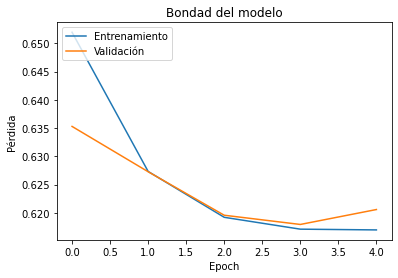

In [87]:
import matplotlib.pyplot as plt

plt.plot(train_output.history["loss"])
plt.plot(train_output.history["val_loss"])
plt.title("Bondad del modelo")
plt.ylabel("Pérdida")
plt.xlabel("Epoch")
plt.legend(["Entrenamiento", "Validación"], loc="upper left")
plt.show()


Con este modelo es sencillo poder componer una función encargada de obtener las películas no vistas con mejor puntuación para un usuario concreto.

In [88]:
def nn_recommender(user_id, num=10):
  """
  Deberemos tener en cuenta la codificación antes empleada a la hora de entrenar el modelo
  """
  # Peliculas vistas
  seen_movies = ratings[ratings["user_id"] == user_id]

  # Películas no vistas
  not_seen = movies[~movies["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()
  not_seen = list(set(not_seen).intersection(set(movie2movie_encoded.keys())))
  not_seen = [[movie2movie_encoded.get(x)] for x in not_seen]

  # User
  encoded_id = user2user_encoded.get(user_id)

  # Input data para el modelo
  input_data  = np.hstack(([[encoded_id]] * len(not_seen), not_seen))
  pred_ratings = model.predict(input_data).flatten()

  # Top ratings
  top_rated = pred_ratings.argsort()[-num:][::-1]

  # Decode
  movie_id = [movie_encoded2movie.get(not_seen[x][0]) for x in top_rated]

  return movies[movies["movie_id"].isin(movie_id)]["title"]

In [89]:
nn_recommender(196)

49                           Star Wars (1977)
63           Shawshank Redemption, The (1994)
271                  Good Will Hunting (1997)
312                            Titanic (1997)
315                 As Good As It Gets (1997)
317                   Schindler's List (1993)
356    One Flew Over the Cuckoo's Nest (1975)
407                     Close Shave, A (1995)
426              To Kill a Mockingbird (1962)
602                        Rear Window (1954)
Name: title, dtype: object

In [90]:
nn_recommender(5)

11                 Usual Suspects, The (1995)
177                       12 Angry Men (1957)
186            Godfather: Part II, The (1974)
222                        Sling Blade (1996)
284                     Secrets & Lies (1996)
301                  L.A. Confidential (1997)
312                            Titanic (1997)
317                   Schindler's List (1993)
356    One Flew Over the Cuckoo's Nest (1975)
514                          Boot, Das (1981)
Name: title, dtype: object

Para hacernos eco de los avances en este ámbito es muy recomendable la lectura del artículo [Deep Learning based Recommender System: A Survey and New Perspectives](https://arxiv.org/abs/1707.07435) de *Zhang et al* ya que da una visión amplia sobre las técnicas y avances al respecto de estas nuevas aproximaciones.

# Modelos basados en árboles

Los arboles de decisión han ganado adeptos también en problemas donde la categorización de elementos no es tan continua como desearíamos. Las redes neuronales funcionan muy bien cuando los datos entrentan cierta continuidad pero cuando nos enfrentamos a datos discretos o categóricos los arboles de decisión pueden mostrar una ventaja significativa.

## Codificación del contexto

Probaremos este hecho incluyendo información relativa a la ocupación y sexo de los usuarios de nuestro conjunto de datos de modo que esto ayude a refinar nuestras ponderaciones. Para ello podremos valernos de las funciones [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=onehot#sklearn.preprocessing.OneHotEncoder) y [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) de *sklearn*.

### Ejercicio

In [91]:
from sklearn import preprocessing

"""
Ejercicio: encontrar la forma de codificar la ocupación de nuestros usuarios 
como columnas on hot encoding y el sexo como un etiquetado
"""

# Obtengamos categorías de sexo y occupación para nuestros usuarios
occupation_cols = users["occupation"].unique().tolist()
users[occupation_cols] = preprocessing.OneHotEncoder(sparse = False).fit_transform(users["occupation"].to_numpy().reshape(-1,1))
users['sex'] = preprocessing.LabelEncoder().fit_transform(users["sex"])

# Obtengamos nuestro conjunto de datos de entrenamiento
x = ratings[['user_id', 'movie_id']]
y = ratings['rating']

selected_cols = occupation_cols + ["user_id", "age","sex"]
x = x.merge(users[selected_cols], on=["user_id","user_id"]).merge(movies[genre_cols + ["movie_id"]], on=["movie_id","movie_id"])
x

,user_id,movie_id,technician,other,writer,executive,administrator,student,lawyer,educator,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,305,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,6,242,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,234,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,63,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,863,1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,0
99996,863,1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
99997,863,1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
99998,896,1681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Modelos ensemble

Tal y como vimos para las redes neuronales podemos emplear modelos concretos que exploten de manera distinta la información contextual disponible tanto de los usuarios como de los ítems. Y en este caso emplearemos un modelo ampliamente conocido en el mundo de la ciencia de datos: [XGBoost](https://xgboost.readthedocs.io/en/stable/#).

Este modelo se compone de conjuntos de árboles de decisión y podemos emplearlo nuevamente para obtener un rating esperado para aquellos casos en los que los datos no se encuentren disponibles (items no valorados).

Seleccionaremos el conjunto de datos a emplear en entrenamiento (90%) frente al de validación (10%).

In [92]:
idx = int(0.9 * x.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

In [93]:
import xgboost as xgb

# Configuramos el modelo en su versión de regressión
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
model_xgb.fit(x_train, y_train)

# Realizamos las prediciones sobre el conjunto de validación
pred = model_xgb.predict(x_val)
rmse = np.sqrt(np.mean((pred - y_val.to_numpy())**2))
print(f'RMSE sobre el rating basado en el contenido = {rmse}')

RMSE sobre el rating basado en el contenido = 1.1299110124868725


In [94]:
def xgb_recommender(user_id, num=10):
  # Peliculas vistas
  seen_movies = ratings[ratings["user_id"] == user_id]

  # Películas no vistas
  not_seen = movies[~movies["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()

  # Ahora podemos refinar nuestra puntuación mediante el modelo XGBoost
  user_data = users[users["user_id"] == user_id][selected_cols]
  movie_data = movies[movies["movie_id"].isin(not_seen)][genre_cols + ["movie_id"]]

  # Obtengamos nuestro conjunto de datos de entrenamiento
  x_data = movie_data
  x_data["user_id"] = user_id
  x_data = x_data.merge(user_data, on=["user_id","user_id"])

  # Obtenemos las predicciones
  pred_xgb = model_xgb.predict(x_data[x.columns])
  ret_df = pd.DataFrame({"movie_id" : movie_data["movie_id"].values, "score" : pred_xgb})
  top_rated = ret_df.sort_values(by="score", ascending=False).head(num)["movie_id"].values.tolist()

  # Devolvemos la lista de las películas mejor valoradas
  return movies[movies["movie_id"].isin(top_rated)]["title"]

In [95]:
xgb_recommender(196)

1231                   Madonna: Truth or Dare (1991)
1546                                Show, The (1995)
1560      Tigrero: A Film That Was Never Made (1994)
1561    Eye of Vichy, The (Oeil de Vichy, L') (1993)
1584                           American Dream (1990)
1593                                  Everest (1998)
1628                                Nico Icon (1995)
1640                                 Dadetown (1995)
1648                             Big One, The (1997)
1668                        MURDER and murder (1996)
Name: title, dtype: object

# Modelos híbridos

Los modelos híbridos pretenden beneficiarse de la disparidad que ofrecen los distintos modelos. Algunos más enfocados en capturar las similitudes entre usuarios, otros en capturar bien los potenciales feedbacks (ratings) entre pares usuario e ítem, ... Es una práctica habitual en el mundo de la ciencia de datos combinar modelos en modeladidades *bagging* o *boosting* de forma que la combinación entre distintos modelos nos ofrezca lo mejor de ambos.

Para una lectura extensa sobre la hibridación y su relevancia en el ámbito de los recomendadores tenéís el artículo de *Çano y Morisio* [Hybrid Recommender Systems: A Systematic Literature Review](https://arxiv.org/abs/1901.03888).

Nosotros podremos hacer una primera aproximación sencilla, simplemente empleando dos de los modelos previamente empleados. Existen multitud de opciones dentro de cómo combinar modelos. Bien sopesando de forma que podamos ponderar sus decisiones o simplemente promediando la decisión entre ambos modelos como veremos a continuación.

### Ejercicio

In [96]:
def hybrid_recommender(user_id, num=10):

  """
  Ejercicio: combinar dos de los modelos anteriormente entrenados para poder así 
  combinar los resultados y mejorar nuestras predicciones. Puede ser una 
  combinación sencilla que simplemente pondere ambas puntuaciones.
  """
  # Peliculas vistas
  seen_movies = ratings[ratings["user_id"] == user_id]

  # Películas no vistas
  not_seen = movies[~movies["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()

  # Empleamos la red neuronal en primera instancia
  not_seen_enc = list(set(not_seen).intersection(set(movie2movie_encoded.keys())))
  not_seen_enc = [[movie2movie_encoded.get(x)] for x in not_seen_enc]

  # User
  encoded_id = user2user_encoded.get(user_id)

  # Input data para el modelo
  input_data  = np.hstack(([[encoded_id]] * len(not_seen_enc), not_seen_enc))
  pred_ratings = model.predict(input_data).flatten()

  # Montamos un DataFrame
  nn_df = pd.DataFrame({"movie_id" : not_seen, "nn_score" : pred_ratings})

  # Ahora podemos refinar nuestra puntuación mediante el modelo XGBoost
  user_data = users[users["user_id"] == user_id][selected_cols]
  movie_data = movies[movies["movie_id"].isin(not_seen)][genre_cols + ["movie_id"]]

  # Obtengamos nuestro conjunto de datos de entrenamiento
  x_data = movie_data
  x_data["user_id"] = user_id
  x_data = x_data.merge(user_data, on=["user_id","user_id"])

  # Obtenemos las predicciones
  pred_xgb = model_xgb.predict(x_data[x.columns])
  xgb_df = pd.DataFrame({"movie_id" : movie_data["movie_id"].values, "xgb_score" : pred_xgb})

  # Contruimos el dataframe que combine ambas puntuaciones
  ret_df = xgb_df.merge(nn_df, on=["movie_id","movie_id"])
  ret_df["score"] = (ret_df["nn_score"]+ret_df["xgb_score"])/10.0
  top_rated = ret_df.sort_values(by="score", ascending=False).head(num)["movie_id"].values.tolist()

  # Devolvemos la lista de las películas mejor valoradas
  return movies[movies["movie_id"].isin(top_rated)]["title"]

In [97]:
hybrid_recommender(196)

49                           Star Wars (1977)
63           Shawshank Redemption, The (1994)
271                  Good Will Hunting (1997)
312                            Titanic (1997)
315                 As Good As It Gets (1997)
317                   Schindler's List (1993)
356    One Flew Over the Cuckoo's Nest (1975)
407                     Close Shave, A (1995)
426              To Kill a Mockingbird (1962)
602                        Rear Window (1954)
Name: title, dtype: object

In [98]:
hybrid_recommender(5)

177                       12 Angry Men (1957)
190                            Amadeus (1984)
284                     Secrets & Lies (1996)
312                            Titanic (1997)
317                   Schindler's List (1993)
356    One Flew Over the Cuckoo's Nest (1975)
512                     Third Man, The (1949)
514                          Boot, Das (1981)
526                             Gandhi (1982)
602                        Rear Window (1954)
Name: title, dtype: object